<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning Challenge: Balancing a Pole on a Cart



# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [172]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing dependencies and define helper functions

In [173]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [174]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [175]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [176]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [177]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.02803358 -0.04482078 -0.04145035  0.02407717]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [178]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.02713716 -0.23932454 -0.04096881  0.3033993 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [179]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

# RL Agent : Q-Learning

Before we begin training our Q-Learning agent, we need to first define the state space, action space and reward function. 

### Action Space
The action was defined as {0,1}, which indicates left or right respectively. 

### State Space
However, the state space will need to be further defined. From the table below, we can see that the observation space consists of continuous values, which means there are infinite possible states. Therefore, we will need to convert these continuous values into ranges that represent discrete states.

| Num | Observation | Min | Max |
| --- | --- | --- | --- | 
| 0 | Cart Position | -4.8 | 4.8 |
| 1 | Cart Velocity | -Inf | Inf |
| 2 | Pole Angle | -0.418 rad | 0.418 rad |
| 3 | Pole Angular Velocity | -Inf | Inf  |

In [180]:
def get_bins(cart_position_bin_size, cart_velocity_bin_size, pole_angle_bin_size, pole_angular_velocity_bin_size):
  # Defining the ranges for each type of observation.
  min_cart_position, max_cart_position = -2.4, 2.4                  # Game terminates beyond this range
  min_cart_velocity, max_cart_velocity = -1.2, 1.2                  # Values beyond this range are too big, and can be all grouped into a state
  min_pole_angle, max_pole_angle = -0.209, 0.209                    # Game terminates beyond this range
  min_pole_angular_velocity, max_pole_angular_velocity = -1.2, 1.2  # Values beyond this range are too big, and can be all grouped into a state

  bins = [
      np.linspace(min_cart_position, max_cart_position, cart_position_bin_size-1),
      np.linspace(min_cart_velocity, max_cart_velocity, cart_velocity_bin_size-1),
      np.linspace(min_pole_angle, max_pole_angle, pole_angle_bin_size-1),
      np.linspace(min_pole_angular_velocity, max_pole_angular_velocity, pole_angular_velocity_bin_size-1)
  ]
  return bins

This `get_bins()` function takes in 4 values, which represents the bin size of each observation type. 
We define the range of each observation type is defined as follows:

| Num | Observation | Lower Boundary | Upper Boundary | Reason |
| --- | --- | --- | --- | --- |
| 0 | Cart Position | -2.4 | 2.4 | Game ends beyond this range |
| 1 | Cart Velocity | -1.2 | 1.2 | Although the range is to infinity, values beyond +-1.2 would lead to termination of the game as the velocity is too high |
| 2 | Pole Angle | -0.209 rad | 0.209 rad | Game ends beyond this range |
| 3 | Pole Angular Velocity | -1.2 | 1.2  | Although the range is to infinity, values beyond +-1.2 would lead to termination of the game as the velocity is too high |



In [181]:
observation_bins = get_bins(6, 8, 10, 8)
print("Cart Position: \t\t", observation_bins[0])
print("Cart Velocity: \t\t", observation_bins[1])
print("Pole Angle: \t\t", observation_bins[2])
print("Pole Angular Velocity: \t", observation_bins[3])

Cart Position: 		 [-2.4 -1.2  0.   1.2  2.4]
Cart Velocity: 		 [-1.2 -0.8 -0.4  0.   0.4  0.8  1.2]
Pole Angle: 		 [-0.209   -0.15675 -0.1045  -0.05225  0.       0.05225  0.1045   0.15675
  0.209  ]
Pole Angular Velocity: 	 [-1.2 -0.8 -0.4  0.   0.4  0.8  1.2]


The cell above shows the bins if we split the observation space into 6, 8, 10, 8 bins respectively.

To account for the symmetry of the game around its centre and the fact that direction matters in this game, we divided the value range into an even number of bins. This guarantees that there are an equal number of bins representing the left direction (where the values are less than or equal to 0) and the right direction (where the values are greater than 0), such that there are no bin that has values that represent different directions.

Another factor to consider is the number of bins for each observation type. If there are too few bins, a single state would encompass a large value range, leading to a huge variance. Conversely, if there are too many bins, it would require a large number of episodes to achieve convergence. To strike a balance, we conducted some testing and decided to partition `Cart Position` into 6 bins, `Cart Velocity` and `Pole Angular Velocity` into 8 bins. However, for `Pole Angle`, which we deemed a critical observation requiring more sensitivity and precision (as the goal is to balance the pole), we opted to split it into 10 bins.
 
Here's how to intepret the bins 

Example: 
> `Cart Position` is separated into the following 6 bins.

| Bin | Lower Boundary (<=) | Upper Boundary (<) | 
| --- | --- | --- |
| 0 | -inf | -2.4 |
| 1 | -2.4 | -1.2 |
| 2 | -1.2 | 0 |
| 3 | 0 | 1.2 |
| 4 | 1.2 | 2.4 |
| 5 | 2.4 | inf |

> `Cart Velocity` is separated into the following 8 bins.

| Bin | Lower Boundary (<=) | Upper Boundary (<) | 
| --- | --- | --- |
| 0 | -inf | -1.2 |
| 1 | -1.2 | -0.8 |
| 2 | -0.8 | -0.4 |
| 3 | -0.4 | 0 |
| 4 | 0 | 0.4 |
| 5 | 0.4 | 0.8 |
| 6 | 0.8 | 1.2 |
| 7 | 1.2 | inf |

 
> `Pole Angle` is split into the following 10 bins.

| Bin | Lower Boundary (<=) | Upper Boundary (<) | 
| --- | --- | --- |
| 0 | -inf | -0.209 |
| 1 | -0.209 | -0.15675 |
| 2 | -0.15675 | -0.1045 |
| 3 | -0.1045 | -0.05225 |
| 4 | -0.05225 | 0 |
| 5 | 0 | 0.05225 |
| 6 | 0.05225 | 0.1045 |
| 7 | 0.1045 | 0.15675 |
| 8 | 0.15675 | 0.209 |
| 9 | 0.209 | inf |

> `Pole Angular Velocity` is separated into the following 8 bins.

| Bin | Lower Boundary (<=) | Upper Boundary (<) | 
| --- | --- | --- |
| 0 | -inf | -1.2 |
| 1 | -1.2 | -0.8 |
| 2 | -0.8 | -0.4 |
| 3 | -0.4 | 0 |
| 4 | 0 | 0.4 |
| 5 | 0.4 | 0.8 |
| 6 | 0.8 | 1.2 |
| 7 | 1.2 | inf |




In [182]:
def discrete_states(observation, bins):
  state_idx = []
  for i in range(len(observation)):
    state_idx.append(np.digitize(observation[i], bins[i])) # Assigns each observation into a bin

  return tuple(state_idx)

The function `discrete_states()` takes the provided bins and uses them to discretize the continuous observation space. The function returns a tuple of indices that correspond to the state for each observation. 

For instance, the observation [-0.02004853 0.0182426 0.00702342 0.02360607] will be converted to the tuple of indices (2, 4, 5, 4). These indices can then be used to access the Q-table and retrieve the Q-values associated with this particular state.

---

### Total Number of States and State-Action pairs

Given that we have partitioned the 4 observations into 6, 8, 10, 8 bins, respectively, we now have a total of 3,840 unique states. Consequently, we have a total of 7,680 state-action pairs in the Q-table.


# Q-Learning Policy





### Reward function

In [183]:
def reward_function(done, steps, target_steps):
    # Early termination: The game is done before target_steps were reached.
    if done and steps < target_steps:
      reward = -1
    else:
      reward = 0
    return reward

Now that the state and action space are defined, we need to define the reward function. 

The default reward function assigns a reward of 1 to every step, which is nonoptimal. This is because both favourable and unfavourable actions receive the same reward of 1, which is not appropriate.

To improve the reward function, we decided to introduce penalties for actions that lead to an early termination of the game instead, as the ultimate goal of the game is to survive as long as possible and reach 500 steps. Specifically, state-action pairs that result in early termination will now receive a reward of -1, while those that do not result in early termination will receive a reward of 0.

By assigning a penalty of -1 to the state-action pairs that lead to early termination, we can update these state-action pairs and propagate the negative values to the state-actions that led to the unfavourable state. Hence, the more negative the value associated with a state-action pair, the more unfavourable that state-action is considered to be. This approach helps the agent to learn to avoid actions that lead to an early termination and encourages it to select actions that lead to a longer survival time.



### Training process

First, we declare our parameters and set up the environemnt.

Then, we will loop over as many episodes as needed to train our Q-Learning Agent until it converges.

In each episode, we will update the the `Q-table` using the Q-Learning equation, where the Q-value of the current state-action pair is updated by adding the learning rate times the difference between the new sample (reward and discounted maximum Q-value of the next state) and the old Q-value estimation.

At the end of each episode, if the criteria for convergence has been achieved, training will stop.





### Parameters

| parameters | value | reason |
| --- | --- | --- |
| cart_position_bin_size | 6 | Decided from trial-and-error |
| cart_velocity_bin_size | 8 | Decided from trial-and-error |
| pole_angle_bin_size | 10 | Decided from trial-and-error |
| pole_angular_velocity_bin_size | 8 | Decided from trial-and-error |
| learning_rate | 0.1 | Decided from trial-and-error |
| discount_factor | 0.99 | Future states are highly important as the goal is to survive in the future |
| exploration_rate | 0.25-0.01 | probability that the agent will select a random action (explore) rather than the action with the highest Q-value (exploit) for a given state  |
| target_steps | 500 | This is the goal that we want to achieve. Early termination before `target_steps` are given -1 reward |
| target_consecutive_success | 100 | Criteria for convergence. 100 consecutive episode successes needed to stop training. |


### Epsilon Decay
Additionally, our group decided to add in epsilon decay, which is a technique to gradually reduce the exploration rate over time during training. The idea behind this technique is to start with high exploration rates at the beginning of the training, where the agent needs to explore the environment to learn about the optimal policies. As the training progresses, the exploration rate is gradually reduced to prioritize the exploitation of the already learned policies. 

Linear Epsilon Decay:
- Initial exploration rate is 0.25. 
- Decreases by 0.01 for every 100 episodes until 0.01.


### Note: The training should be completed within 3 minutes.

In [204]:
# Q-Learning to generate Q-table

# Parameters
cart_position_bin_size, cart_velocity_bin_size, pole_angle_bin_size, pole_angular_velocity_bin_size = 6, 8, 10, 8

learning_rate = 0.1
discount_factor = 0.99
exploration_rate = 0.25
target_steps = 500
target_consecutive_success = 100

# Create bins
bins = get_bins(cart_position_bin_size, cart_velocity_bin_size, pole_angle_bin_size, pole_angular_velocity_bin_size)

# Create Q-table with all zeroes. 
Q_table = np.zeros(shape=(cart_position_bin_size, cart_velocity_bin_size, pole_angle_bin_size, pole_angular_velocity_bin_size, 2))

# Set up environment
env = gym.make("CartPole-v1")

results = []
consecutive_success = 0
episode = 0

# Iterate over each episode until convergence
while True:
  
  # Reset the environment for a new episode
  observation = env.reset()
  current_state = discrete_states(observation, bins)
  done = False
  episode += 1
  steps = 0

  # Iterate over each step and update Q-table
  while not done:
    # Choose an action using epsilon-greedy policy
    if np.random.uniform(0,1) < exploration_rate:
      action = env.action_space.sample()          # Exploration: Probability of `exploration_rate` to randomly choose an action from the action space of (0,1)
    else:
      action = np.argmax(Q_table[current_state])  # Exploitation: Probability of 1-`exploration_rate` to choose action that gives the highest Q-value from q_table
    observation, reward, done, info = env.step(action)
    next_state = discrete_states(observation, bins)
    steps += 1

    # Assign reward based on reward function
    reward = reward_function(done=done, 
                             steps=steps, 
                             target_steps=target_steps
                             )


    # Max Q-value of the next state
    max_Q_of_next_state = np.max(Q_table[next_state]) 

    # Old Q-value of current state-action pair
    old_Q_of_current_state_action_pair = Q_table[current_state][action]

    # Update the Q-value for the current state-action pair
    Q_table[current_state][action] += learning_rate * (reward + discount_factor * max_Q_of_next_state - old_Q_of_current_state_action_pair)

    # Update the state
    current_state = next_state
  

# At the end of an episode
  # Print the episode number and avg reward of the past 100 episodes
  results.append(steps)
  if episode % 100 == 0:
    past_100_avg = np.array(results).mean()
    print("Episode {:4}:\t{:3} steps.\tAvg of last 100 episodes:\t{:4}".format(episode, steps, past_100_avg))
    results =[]

    # Linear Epsilon Decay
    if exploration_rate > 0.01:
      exploration_rate -= 0.01 
      print("Episode {:4} exploration rate: {:.2f}".format(episode, exploration_rate))


  # End training when Q-table has converged
  if steps >= target_steps:
    consecutive_success +=1
  else:
    consecutive_success = 0
  if consecutive_success >= target_consecutive_success:
    print("Episode {:4}: Policy has converged with {} consecutive success.".format(episode, target_consecutive_success))
    break
  


Episode  100:	 29 steps.	Avg of last 100 episodes:	50.87
Episode  100 exploration rate: 0.24
Episode  200:	212 steps.	Avg of last 100 episodes:	165.96
Episode  200 exploration rate: 0.23
Episode  300:	 12 steps.	Avg of last 100 episodes:	119.51
Episode  300 exploration rate: 0.22
Episode  400:	240 steps.	Avg of last 100 episodes:	156.73
Episode  400 exploration rate: 0.21
Episode  500:	290 steps.	Avg of last 100 episodes:	228.93
Episode  500 exploration rate: 0.20
Episode  600:	354 steps.	Avg of last 100 episodes:	308.93
Episode  600 exploration rate: 0.19
Episode  700:	192 steps.	Avg of last 100 episodes:	264.88
Episode  700 exploration rate: 0.18
Episode  800:	279 steps.	Avg of last 100 episodes:	321.66
Episode  800 exploration rate: 0.17
Episode  900:	224 steps.	Avg of last 100 episodes:	330.54
Episode  900 exploration rate: 0.16
Episode 1000:	350 steps.	Avg of last 100 episodes:	250.64
Episode 1000 exploration rate: 0.15
Episode 1100:	223 steps.	Avg of last 100 episodes:	262.91
Epi

In [205]:
def Q_Learning_RL_Agent(observation):
    # Use learned Q-table to return an action
    current_state = discrete_states(observation, bins)
    return np.argmax(Q_table[current_state])


The `Q_Learning_RL_Agent` can now use the `Q_table` to play the game. It can do this by first converting the observation into a discrete state and then using the current_state to index the relevant `Q_table` entry. From this entry, the action with the maximum Q-value for that state can be determined using `np.argmax()`.

For Task 1, we can show the observation and chosen action below:

In [206]:
observation = env.reset()
action = Q_Learning_RL_Agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.04586409 -0.00418321  0.02016653 -0.03933192]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

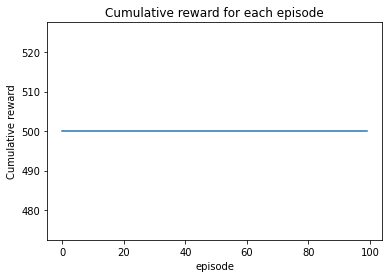

In [207]:
env = gym.make("CartPole-v1")
num_episodes = 100

episode_results = []
for episode in range(num_episodes):
  done = False
  cumulative_reward = 0

  observation = env.reset() #restart game

  while not done:
    action = Q_Learning_RL_Agent(observation)
    observation, reward, done, info = env.step(action)
    cumulative_reward += reward
  episode_results.append(cumulative_reward)

episode_results = np.array(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


Print the average reward over the 100 episodes.

In [208]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [209]:
env1 = gym.make("CartPole-v1")
env1._max_episode_steps = 500

env = RecordVideo(env1, "./video")
observation = env.reset()
print("Initial observation:", observation) 
cumulative_reward = 0
while True:
    env.render()

    #your agent goes here
    action = Q_Learning_RL_Agent(observation)
    observation, reward, done, info = env.step(action) 
    cumulative_reward += reward
    if done: 
      break;
    

print("Cumulative reward for this round:", cumulative_reward)    
env.close()
show_video()

Initial observation: [ 0.02966258  0.03072034  0.02521789 -0.04590504]
Cumulative reward for this round: 500.0
